In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.datasets import make_circles, make_classification,make_blobs, make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import math
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

## 1. AdaBoost implementation

In [13]:
class MyAdaBoostBinary:
    def __init__(self, 
                 max_depth=1, 
                 n_estimators=10,
                 verbose=True,
                 random_state=None):
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.verbose = verbose
        self.random_state = random_state
        self.base_models = []
        self.training_errors = []

    def _get_estimator(self):
        # Will use tree as base estimator
        return DecisionTreeClassifier(max_depth=self.max_depth, splitter='best', criterion='gini', random_state=self.random_state)
        
    def fit(self, X, y):
        def calc_eps(weigths, y, predictions):
            errors = (y != predictions)
            return (weigths * errors).sum()
    
        sample_count = len(X)
        
        # Init initial weights
        cur_weigths = np.ones(sample_count) / sample_count

        for t in range(self.n_estimators):
            model = self._get_estimator()
            
            # Train base estimator
            model.fit(X, y, sample_weight=cur_weigths)
            
            predictions = model.predict(X)    
            
            # Calculate weighted error of classification
            eps = calc_eps(cur_weigths, y, predictions)
                
            # If error > 0.5 this means that this very bad estimator
            if eps >= 0.5:
                break
            
            # Calculate "power" of estimator. alpha will be more for better estimator
            alpha = 0.5 * np.log( (1-eps)/eps )
            
            # Recalculate weights - incorrect predictions will have greater weights, correct - less
            # and normalization
            cur_weigths *= np.exp(-alpha*y*predictions)
            cur_weigths /= cur_weigths.sum()

            self.base_models.append((model, alpha))
            
            if self.verbose:
                print(f"Base model: {t}, error: {eps:.3f}, alpha: {alpha:.3f}")

        return self
    
    def score(self, X, y_true):
        y_pred = self.predict(X)
        return accuracy_score(y_pred, y_true)
        
    def predict(self, X, n_estimators=None):
        '''
            Calculate result as sum of predictions for base estimators with alphas as "power"
            of estimator
        '''
            
        sample_count = len(X)
 
        y_pred = np.zeros(sample_count)

        if not n_estimators or n_estimators > self.n_estimators:
            n_estimators = self.n_estimators
            
        for model, alpha in self.base_models[:n_estimators]:
            model_pred = model.predict(X)
            y_pred += alpha*model_pred

        return np.sign(y_pred)
    
    def plot_trees(self, ncols=1):
        def get_optimal_axes(ncols):
            base_models_count = len(self.base_models)
            base_models_depth = ada_model.max_depth

            nrows = math.ceil(base_models_count / ncols)

            fig, ax = plt.subplots(nrows=nrows, ncols=ncols)

            fig.set_figheight(5*nrows*base_models_depth)
            fig.set_figwidth(6*ncols*base_models_depth)

            return ax.ravel()

        axes = get_optimal_axes(ncols)
        for i in range(len(self.base_models)):
            base_model = self.base_models[i][0]
            base_model_alpha = self.base_models[i][1]
            ax = axes[i]

            plot_tree(base_model,  filled=True, node_ids=True, fontsize=12, feature_names=df_X.columns, class_names=["-1","1"], ax=ax)
            ax.set_title(f"Tree {i} (alpha={base_model_alpha:.3f})")

## 2. Check model

In [14]:
def remap_y(y):
    return pd.Series(y).map({
        0: -1,
        1: 1
    })

def create_df_X(X):
    return  pd.DataFrame({
            "x1" : X[:,0],
            "x2" : X[:,1],
        })

### Load data

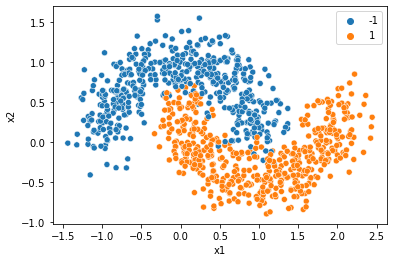

In [15]:
X, y = make_moons(n_samples=1000, noise=0.2, random_state=27)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

<AxesSubplot:xlabel='x1', ylabel='x2'>

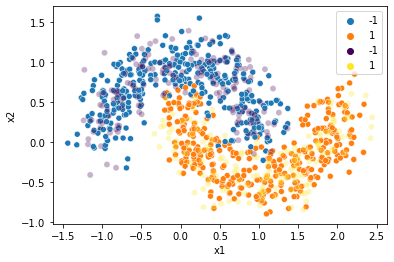

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_X, y, test_size=0.3)

sns.scatterplot(data=X_train, x="x1", y="x2", hue=y_train, palette="tab10")
sns.scatterplot(data=X_test,  x="x1", y="x2", hue=y_test, ax=plt.gca(), palette="viridis", alpha=0.3)

### Check trees in our model

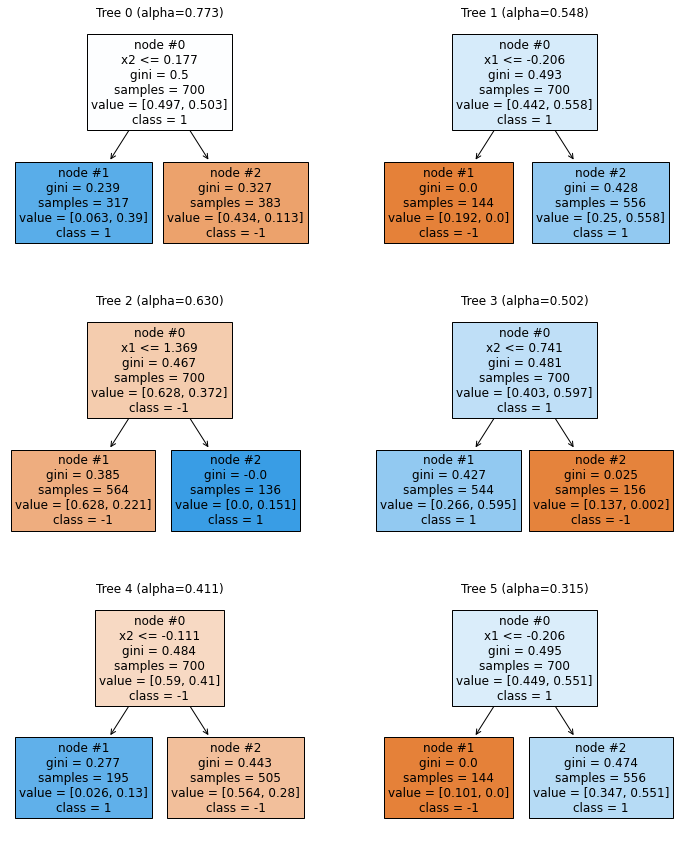

In [17]:
ada_model = MyAdaBoostBinary(n_estimators=6, max_depth=1, verbose=False)
ada_model.fit(X_train, y_train)

ada_model.plot_trees(ncols=2)


### Find the best n_estimators

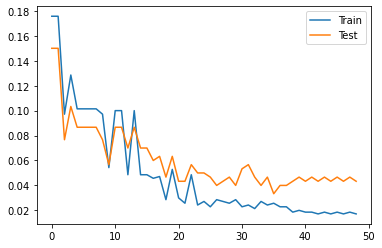

In [18]:
def plot_errors(X_train, y_train, X_test, y_test, N):
    train_errors = []
    test_errors = []
    sample_count = len(X)
    
    ada_model = MyAdaBoostBinary(n_estimators=N,verbose=False)
    ada_model.fit(X_train, y_train)
        
    for n in range(1,N):
        y_train_pred = ada_model.predict(X_train, n)
        errors_count = (y_train_pred != y_train).sum() / len(X_train)
        train_errors.append(errors_count)
        
        y_test_pred = ada_model.predict(X_test, n)
        errors_count = (y_test_pred != y_test).sum() / len(X_test) 
        test_errors.append(errors_count)
        
    plt.plot(train_errors, label="Train")
    plt.plot(test_errors, label="Test")
    plt.legend()
    
plot_errors(X_train, y_train, X_test, y_test, 50)

### Get score for model

In [19]:
def check_model(X, y, N=10, max_depth=2, verbose=False):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=1)

    ada_model = MyAdaBoostBinary(n_estimators=N, max_depth=max_depth,verbose=verbose)
    ada_model.fit(X_train, y_train)

    print(f'Train, accuracy: {ada_model.score(X_train, y_train):.5f}')
    print(f'Test, accuracy: {ada_model.score(X_test, y_test):.5f}')

check_model(X, y, N=20)

Train, accuracy: 0.98857
Test, accuracy: 0.96333


## 3.Check model on another datasets

### 1. Circle

Train, accuracy: 1.00000
Test, accuracy: 0.99000


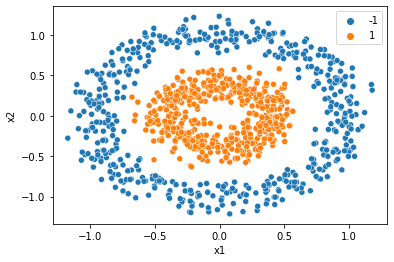

In [20]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.4)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

check_model(X, y, N=25)

### 2. Classification

Train, accuracy: 0.92714
Test, accuracy: 0.92333


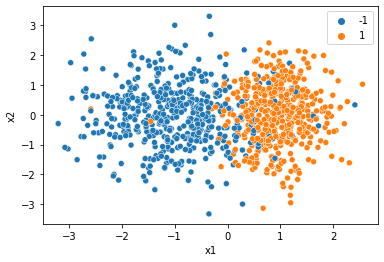

In [21]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1,\
                          class_sep=1,random_state=2)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

check_model(X, y, N=25)

### 3. Blobs

Train, accuracy: 0.86429
Test, accuracy: 0.87000


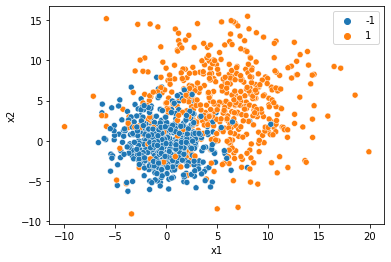

In [22]:
X, y = make_blobs(n_samples=1000, cluster_std=[2.5, 4.5], center_box=(0,10), centers=[(0,0),(5,5)], random_state=2)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

model = check_model(X, y, N=10)

As we can see we have a very good result for clusters with small variance, and not the best for mixed data. Noisy data and outliers have to be avoided before adopting an Adaboost algorithm

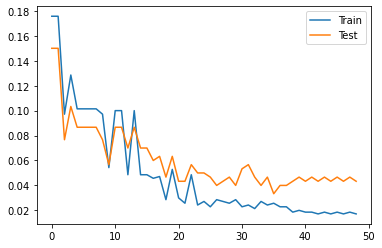

In [23]:
def plot_errors(X_train, y_train, X_test, y_test, N):
    train_errors = []
    test_errors = []
    sample_count = len(X)
    
    ada_model = MyAdaBoostBinary(n_estimators=N,verbose=False)
    ada_model.fit(X_train, y_train)
        
    for n in range(1,N):
        y_train_pred = ada_model.predict(X_train, n)
        errors_count = (y_train_pred != y_train).sum() / len(X_train)
        train_errors.append(errors_count)
        
        y_test_pred = ada_model.predict(X_test, n)
        errors_count = (y_test_pred != y_test).sum() / len(X_test) 
        test_errors.append(errors_count)
        
    plt.plot(train_errors, label="Train")
    plt.plot(test_errors, label="Test")
    plt.legend()
    
plot_errors(X_train, y_train, X_test, y_test, 50)

### Get score for model

In [24]:
def check_model(X, y, N=10, max_depth=2, verbose=False):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=1)

    ada_model = MyAdaBoostBinary(n_estimators=N, max_depth=max_depth,verbose=verbose)
    ada_model.fit(X_train, y_train)

    print(f'Train, accuracy: {ada_model.score(X_train, y_train):.5f}')
    print(f'Test, accuracy: {ada_model.score(X_test, y_test):.5f}')

check_model(X, y, N=20)

Train, accuracy: 0.86714
Test, accuracy: 0.87333


## 3.Check model on another datasets

### 1. Circle

Train, accuracy: 1.00000
Test, accuracy: 0.99667


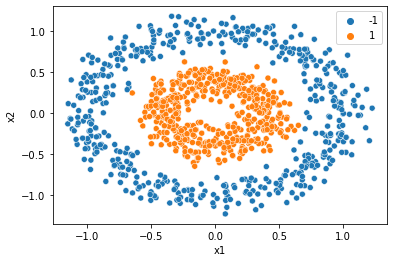

In [25]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.4)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

check_model(X, y, N=25)

### 2. Classification

Train, accuracy: 0.92714
Test, accuracy: 0.92333


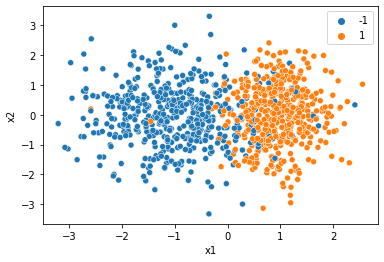

In [26]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1,\
                          class_sep=1,random_state=2)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

check_model(X, y, N=25)

### 3. Blobs

Train, accuracy: 0.86429
Test, accuracy: 0.87000


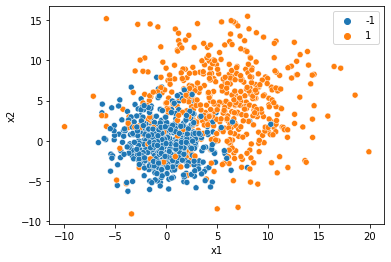

In [27]:
X, y = make_blobs(n_samples=1000, cluster_std=[2.5, 4.5], center_box=(0,10), centers=[(0,0),(5,5)], random_state=2)

y = remap_y(y)
df_X = create_df_X(X)

ax = sns.scatterplot(data=df_X, x="x1", y="x2", hue=y,palette="tab10")

model = check_model(X, y, N=10)

As we can see we have a very good result for clusters with small variance, and not the best for mixed data. Noisy data and outliers have to be avoided before adopting an Adaboost algorithm